In [205]:
import warnings
import os
import sys
# try to import peal and if not installed, add the parent directory to the path
try:
    import peal

except ImportError:
    # if peal not installed, but project downloaded locally
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

# import basic libraries needed for sure and set the device depending on whether cuda is available or not
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

warnings.filterwarnings('ignore')

In [206]:
from peal.global_utils import load_yaml_config
from peal.data.datasets import SymbolicDataset

unpoisened_dataset_config = load_yaml_config('<PEAL_BASE>/configs/data/circle_dataset_diffusion_unpoisened.yaml')

dataset = SymbolicDataset(data_dir=unpoisened_dataset_config.dataset_path, mode='train', config=unpoisened_dataset_config)

In [207]:
train_size = int(0.95 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size 
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [491]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
from typing import Tuple
import logging
from torch.utils.data import DataLoader
import math
%matplotlib inline

logging.getLogger().setLevel(logging.INFO)

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=500):

        super(PositionalEncoding, self).__init__()
        max_len += 1
        self.P = torch.zeros(max_len, embed_dim)
        freqs = torch.arange(max_len)[:, None] / (torch.pow(10000, torch.arange(0, embed_dim, 2, dtype=torch.float32)/embed_dim))

        self.P[:,0::2] = torch.sin(freqs)
        self.P[:,1::2] = torch.cos(freqs)
        
        self.P = self.P[1:]
        
    def forward(self, t):
        return self.P[t]
    
class ScoreNetwork(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super(ScoreNetwork, self).__init__()
        self.embed_dim = embed_dim
        self.layer1 = nn.LazyLinear(embed_dim)
        self.layer2 = nn.LazyLinear(embed_dim)
        self.layer3 = nn.LazyLinear(embed_dim)
        self.norm = nn.LayerNorm(embed_dim)
        self.layer4 = nn.LazyLinear(input_dim)
    
    def forward(self, x, time_embed):
        x = self.layer1(x) + time_embed
        x = F.silu(self.layer2(x))
        x = F.silu(self.layer3(x))  
        return self.layer4((self.norm(x)))
                           
class BasicDiscreteTimeModel(nn.Module):
    def __init__(self, input_dim: int, embed_dim: int, num_timesteps: int):
        super(BasicDiscreteTimeModel, self).__init__()

        self.positional_embeddings = PositionalEncoding(embed_dim=embed_dim, max_len=num_timesteps)
        self.score_network = ScoreNetwork(input_dim=input_dim, embed_dim=embed_dim)

    def forward(self, x, t):

        time_embed = self.positional_embeddings(t)
        return self.score_network(x, time_embed)

    

class CircleDiffusionAdaptor(nn.Module):
    def __init__(self, config, dataset, model_dir=None):
        super(CircleDiffusionAdaptor, self).__init__()
        # self.config = load_yaml_config(config)
        self.config = config
        
        if not model_dir is None:
            self.model_dir = model_dir
        else:
            self.model_dir = config['base_path']
        
        #if not os.path.exists(model_dir):
        #    os.mkdir(model_dir)
        #self.model_dir = model_dir
        self.input_dim = config['input_dim']
        try: 
            self.num_timesteps = config['num_timesteps']
        except KeyError: 
            pass
        
        self.dataset = dataset
        self.input_idx = [idx for idx, element in enumerate(self.dataset.attributes) if element not in ['Confounder', 'Target']]
        self.target_idx = [idx for idx, element in enumerate(self.dataset.attributes) if element == 'Target']
        #data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
        #for idx, key in enumerate(dataset.data):
        #    data[idx] = dataset.data[key]
        #self.model = self.train_and_load_diffusion(model_name='diffusion.pth')
        
        def schedules(num_timesteps: int, type: str='linear'):
 
            if type=='linear':
                scale = 1000 / num_timesteps
                min_var = scale * 1e-4
                max_var = scale * 1e-2
                return torch.linspace(min_var, max_var, num_timesteps, dtype=torch.float32)
            elif type=='cosine':
                steps = num_timesteps + 1
                x = torch.linspace(0, num_timesteps, steps, dtype=torch.float64)
                alphas_cumprod = torch.cos(((x / num_timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
                alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
                betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
                return torch.clip(betas, 0, 0.999)
        
        betas = schedules(num_timesteps=config['num_timesteps'], type=config['var_schedule'])

        self.register_buffer("beta", betas)
        self.register_buffer("alpha", 1 - self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(0))
        
        
    def forward_diffusion(self, clean_x: torch.Tensor, noise: torch.tensor, timestep: torch.Tensor):
        
        if isinstance(timestep, int):
            timestep = torch.tensor([timestep])
            alpha_bar_t = self.alpha_bar[timestep].repeat(clean_x.shape[0])[:, None]
        else:
            alpha_bar_t = self.alpha_bar[timestep][:, None]
        mu = torch.sqrt(alpha_bar_t)
        std = torch.sqrt(1 - alpha_bar_t)
        noisy_x = mu * clean_x + std * noise
        return noisy_x
    

    def reverse_diffusion_ddpm(self, noisy_x: torch.Tensor, model: nn.Module, timestep: torch.Tensor):
        alpha_t = self.alpha[timestep].repeat(noisy_x.shape[0])[:, None]
        alpha_bar_t = self.alpha_bar[timestep].repeat(noisy_x.shape[0])[:, None]
        beta_t = 1 - alpha_t
        eps_hat = model(x=noisy_x, t=timestep)
        posterior_mean = (1 / torch.sqrt(alpha_t)) * (noisy_x - (beta_t / torch.sqrt(1 - alpha_bar_t) * eps_hat))
        z = torch.randn_like(noisy_x)
        
        if timestep > 0:
            alpha_bar_t_minus_1 = self.alpha_bar[timestep-1].repeat(noisy_x.shape[0])[:, None]
            sigma_t = beta_t * (1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t)
            denoised_x = posterior_mean + torch.sqrt(sigma_t)*z #* z * (timestep > 0))  # variance = beta_t
        else:
            denoised_x = posterior_mean
                                           
        return denoised_x
    
    def train_and_load_diffusion(self, model_name='diffusion.pt', mode=None):
        
        self.model_path = os.path.join(self.model_dir, model_name)
        model = BasicDiscreteTimeModel(input_dim=self.config['input_dim'], embed_dim=self.config['embed_dim'], num_timesteps=self.config['num_timesteps'])
        if model_name in os.listdir(self.model_dir) and not mode == "train":
            model.load_state_dict(torch.load(self.model_path))
            logging.info(f'Model found with path {self.model_path}')
        elif model_name not in os.listdir(self.model_dir) and mode != 'train':
            logging.info('Model not found. Please run train_and_load_diffusion method and set its argument mode="train" ')
        else:
            logging.info(
                f'Training model with path {self.model_path}'
            )
        
        def diffusion_loss(model: nn.Module, clean_x: torch.Tensor) -> torch.Tensor:
            t = torch.randint(self.num_timesteps, (clean_x.shape[0],))
            eps_t = torch.randn_like(clean_x)
            alpha_bar_t = self.alpha_bar[t][:, None]
            x_t = self.forward_diffusion(clean_x=clean_x, noise=eps_t, timestep=t)
            eps_hat = model(x=x_t, t=t)
            loss_diff = nn.MSELoss(reduction='sum')(eps_hat, eps_t)
            
            return loss_diff
                    
        def run_epoch(model: nn.Module, dataloader: torch.utils.data.dataloader.DataLoader):
            model.train()
            epoch_loss = 0.0

            for x, _ in dataloader:
                optimizer.zero_grad()
                loss = diffusion_loss(model, x[:, self.input_idx])
                epoch_loss += loss
                loss.backward()
                optimizer.step()
                
            return epoch_loss / len(dataloader.dataset)
        
        if mode == 'train':
            model.train()
            num_epochs = self.config['num_epochs']
            dataloader = DataLoader(self.dataset, batch_size=self.config['batch_size'], shuffle=True)
            learning_rate = 1e-4
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
            losses = []
            for i in trange(num_epochs):
                epoch_loss = 0.0
                for x, _ in dataloader:
                    optimizer.zero_grad()
                    loss = diffusion_loss(model, x[:, self.input_idx])
                    epoch_loss += loss
                    loss.backward()
                    optimizer.step()

                train_loss = epoch_loss / len(dataloader.dataset)
                print(f'Epoch: {i}, train_loss: {train_loss}')
                losses.append(train_loss.detach().numpy())
            
            torch.save(model.state_dict(), self.model_path) 
            
        self.model = model
    
    @torch.no_grad()
    def sample_ddpm(self, model: nn.Module, n_samples: int = 256, label=None):
        """
        iteratively denoises pure noise to produce a list of denoised samples at each timestep
        """
        model.eval()
        
        x_pred = []
        x = torch.randn(n_samples, self.input_dim)
        x_pred.append(x)

        for t in reversed(range(0, self.num_timesteps)):
                
            x = self.reverse_diffusion_ddpm(noisy_x=x, model=model, timestep=t)
                
            x_pred.append(x)
        return x_pred
    
    def sample_x(self, batch_size=1):
        x = self.sample_ddpm(model=self.model, n_samples=batch_size)[-1] 
        return x

    def sample_counterfactual_ddpm(self, clean_batch: torch.Tensor, model: nn.Module, classifier: nn.Module, num_noise_steps: int, target_classes: int, classifier_grad_weight: float):
        
        
        classifier.eval()
        self.classifier = classifier
        
        # DEFINE BATCH SIZE AND COUNTERFACTUAL CLASS
        bs = clean_batch.shape[0]

        # COMPUTE CLEAN GRADIENTS FOR THE FIRST STEP
        
        classifier_criterion = lambda x: F.cross_entropy(classifier(x), target_classes)
        clean_batch_copy = torch.nn.Parameter(clean_batch)
        loss = classifier_criterion(clean_batch_copy)
        loss.backward()
        clean_grad = classifier_grad_weight * clean_batch_copy.grad.detach()
        
        # PERFORMING FORWARD DIFFUSION UNTIL NUM_NOISE_STEPS
        eps_t = torch.randn_like(clean_batch)
        next_z = self.forward_diffusion(clean_x=clean_batch, noise=eps_t, timestep=num_noise_steps)
        counterfactuals = [] # total counterfactuals
        counterfactuals.append(clean_batch)
        guided_grads = []  # guided grads at the first step
        unconditional_grads = [] # diffusion grads at the first step
        total_series = [] # contains evolution from noisy to cleaned instance for each data point
        for i in tqdm(range(0, num_noise_steps)[::-1]):
            # Denoise z_t to create z_t-1 (next z)
            alpha_i = self.alpha[i].repeat(bs)[:, None]
            alpha_bar_i = self.alpha_bar[i].repeat(bs)[:, None]
            sigma_i = torch.sqrt(1 - self.alpha[i])
            eps_hat = model(next_z, i)

            # Unconditional mean
            unconditional_grad = -eps_hat / torch.sqrt(1 - alpha_bar_i)
            z_t_mean = (next_z + unconditional_grad * (1 - alpha_i)) / torch.sqrt(alpha_i)

            # Guided mean
            z_t_mean -= sigma_i * (clean_grad / torch.sqrt(alpha_bar_i))

            if i > 0:
                next_z = z_t_mean + (sigma_i * torch.randn_like(clean_batch))
            else:
                next_z = z_t_mean

            next_x = next_z.clone()
            # Denoise to create a cleaned x (next x)
            series = []
            series.append(next_x.detach())
            for t in range(0, i)[::-1]:
                if i == 0:
                    break
                next_x = self.reverse_diffusion_ddpm(noisy_x=next_x, model=model, timestep=t)
                series.append(next_x.detach())
            total_series.append(series)
            guided_grads.append(-sigma_i * clean_grad.detach() / torch.sqrt(alpha_bar_i))
            unconditional_grads.append(unconditional_grad.detach() * (1 - alpha_i) / torch.sqrt(alpha_i) )
            
            
            if i != 0:
                counterfactuals.append(next_x.detach())

            # Gradient wrt denoised image (next_x)
            next_x_copy = torch.nn.Parameter(next_x.clone())
            loss = classifier_criterion(next_x_copy)
            loss.backward()
            clean_classifier_grad = next_x_copy.grad.detach()
            clean_grad = classifier_grad_weight * clean_classifier_grad
            
            #self.counterfactuals = counterfactuals
            #self.guided_grads = guided_grads
            #self.diffusion_grads = unconditional_grads
            #self.pointwise_evolution = total_series 
            
        counterfactuals = torch.stack(counterfactuals).permute(1, 0, 2) 
        guided_grads = torch.stack(guided_grads).permute(1, 0, 2) 
        unguided_grads = torch.stack(unconditional_grads).permute(1, 0, 2)
        
        self.counterfactuals_series = counterfactuals
        
        return counterfactuals, guided_grads, unguided_grads, total_series

    
    def discard_counterfactuals(self, counterfactuals, classifier, target_classes, target_confidence, minimal_counterfactuals, tolerance=0.1):
        
        # compute distance of current minimal_counterefactuals from radius 1.0
        #current_counterfactual_distance_from_manifold = torch.abs((torch.pow(minimal_counterfactuals, 2).sum(dim=-1) - 1.0))
        
        for i in range(len(counterfactuals)):  

            # compute classifier  for all the counterfactuals for each point
            new_counterfactuals_confidence = classifier(counterfactuals[i]).softmax(dim=-1)[:, target_classes[i]]
            
            
            # check if new counterfactuals satisfy the confidence constraint
            new_confidence_satisfied = new_counterfactuals_confidence > target_confidence
            
            new_confidence_satisfied_indices = torch.nonzero(new_counterfactuals_confidence > target_confidence)
            
            
            # 
            #new_tolerance_satisfied = torch.abs((torch.pow(counterfactuals[i], 2).sum(dim=-1) - 1.0)) < tolerance
            #new_tolerance_satisfied_indices = torch.nonzero(torch.abs((torch.pow(counterfactuals[i], 2).sum(dim=-1) - 1.0)) < tolerance)
            
            # check where target confidence is reached AND if new counterfactuals are within the tolerance range
            #indices = torch.nonzero((confidence > target_confidence) 
            #                    (torch.abs((torch.pow(counterfactuals[i], 2).sum(dim=-1) - 1.0)) < tolerance))
            
            
            #new_confidence_and_tolerance_satisfied_indices = torch.nonzero(new_confidence_satisfied & new_tolerance_satisfied)
            
            #current_tolerance_satisfied = current_counterfactual_distance_from_manifold[i] < tolerance
            #classifier(minimal_counterfactuals[i:i+1]).softmax(dim=-1)[0][target_classes[i]]
            current_confidence_satisfied = classifier(minimal_counterfactuals[i:i+1]).softmax(dim=-1)[0][target_classes[i]].item() > target_confidence
            
            # if current counterfactual satisfies confidence and tolerance, maintain status quo 
            
            if (current_confidence_satisfied):
                continue
          
            elif new_confidence_satisfied_indices.nelement() != 0:
                minimal_counterfactuals[i] = counterfactuals[i][new_confidence_satisfied_indices[0].item()]
                
            else:
                minimal_counterfactuals[i] = counterfactuals[i][-1]
                
            # if new target confidence and current target confidence not satisfied
            # but new tolerance is satisfied, then move the point closer
            #elif (new_tolerance_satisfied_indices.nelement() !=0) & (new_confidence_satisfied_indices.nelement() == 0) and (not current_confidence_satisfied):
            #    minimal_counterfactuals[i] = counterfactuals[i][torch.nonzero(new_tolerance_satisfied)[-1].item()]
            
              
            # if current counterfactual is on the manifold but is not actually a counterfactual, 
            # replace it with new counterfactual if there exists any 
            #elif (not current_confidence_satisfied) & (new_confidence_and_tolerance_satisfied_indices.nelement() != 0):
            #    # change this to only include the first where confidence and tolerance is satisfied
            #    minimal_counterfactuals[i] = counterfactuals[i][new_confidence_and_tolerance_satisfied_indices[0].item()]
                
            #else:
            #    continue
            

        return minimal_counterfactuals
        
        
    def edit(
        self,
        x_in: torch.Tensor,
        target_confidence_goal: float,
        target_classes: torch.Tensor,
        classifier: nn.Module
    ) -> Tuple[list[torch.Tensor], list[torch.Tensor], list[torch.Tensor], list[torch.Tensor]]:
        
        self.original_sample = x_in
        #minimal_counterfactuals = torch.zeros(size=x_in.shape)

        scales = self.config['grad_scales']
        noise_steps = self.config['noise_steps_for_counterfactuals']
        
        minimal_counterfactuals = x_in.clone()
        
        for it in range(self.config['num_iterations']):
            for steps in noise_steps:

                for s in scales:

                    counterfactuals, guided_grads, unguided_grads, total_series = self.sample_counterfactual_ddpm(clean_batch=minimal_counterfactuals, model=self.model, classifier=classifier, num_noise_steps=steps, target_classes=target_classes, classifier_grad_weight=s)

                    minimal_counterfactuals = self.discard_counterfactuals(counterfactuals=counterfactuals, classifier=classifier, target_confidence=target_confidence_goal, target_classes=target_classes, minimal_counterfactuals=minimal_counterfactuals)
                    self.counterfactuals = minimal_counterfactuals
                    flip_rate = sum(classifier(minimal_counterfactuals).softmax(dim=-1).argmax(dim=-1) != classifier(x_in).softmax(dim=-1).argmax(dim=-1)) / len(x_in)
                    self.plot_counterfactuals()
                    plt.title(f'Noise Steps: {steps}, Gradient Scale: {s}, Flip Rate: {round(flip_rate.item(),3)}')
                    #plt.show()
        list_counterfactuals = [row_tensor for row_tensor in minimal_counterfactuals]
        diff_latent = x_in - minimal_counterfactuals
        
        confidences = classifier(minimal_counterfactuals).softmax(dim=-1)
        y_target_end_confidence = [confidences[i][target_classes[i]].detach() for i in range(len(minimal_counterfactuals))]
        x_list = [row_tensor for row_tensor in x_in]
        
        #self.counterfactuals = minimal_counterfactuals
        
        return list_counterfactuals, diff_latent, y_target_end_confidence, x_list
    
    
    def plot_counterfactuals(self):
        plt.figure(figsize=(5,5))
        data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
        for idx, key in enumerate(dataset.data):
            data[idx] = dataset.data[key]
        self.data = data
        plt.scatter(data[:,self.input_idx[0]], data[:,self.input_idx[1]], c=np.where(data[:,self.target_idx] == 0, 'lightcyan', 'lightgray')[0])
        for i, point in enumerate(self.counterfactuals):
            plt.scatter(self.original_sample[i, 0], self.original_sample[i, 1], color='green', label='start')
            plt.scatter(point[0], point[1], color='red', label='end')
            plt.arrow(
                self.original_sample[i,0], self.original_sample[i, 1], # plot the original point plus arrow until (j+granularity)th point
                point[0] - self.original_sample[i, 0], 
                point[1] - self.original_sample[i, 1],
                head_width=0.05, head_length=0.05, fc='blue', ec='blue',

            )
        
        #plt.show()
    
    
    
        

In [492]:
adaptor_config = load_yaml_config('<PEAL_BASE>/configs/adaptors/circle_diffusion.yaml')
adaptor = CircleDiffusionAdaptor(config=load_yaml_config(adaptor_config).generator, dataset=train_set.dataset, model_dir=None)
adaptor.train_and_load_diffusion(model_name='diffusion.pt')#, mode='train')
student = torch.load('peal_runs/artificial_circle_poisened_classifier/model.cpl')
teacher = torch.load('peal_runs/artificial_circle_unpoisened_classifier/model.cpl')


INFO:root:Model found with path peal_runs/artificial_circle_diffusion_generator/diffusion.pt


In [422]:
series = adaptor.sample_ddpm(adaptor.model, 100)

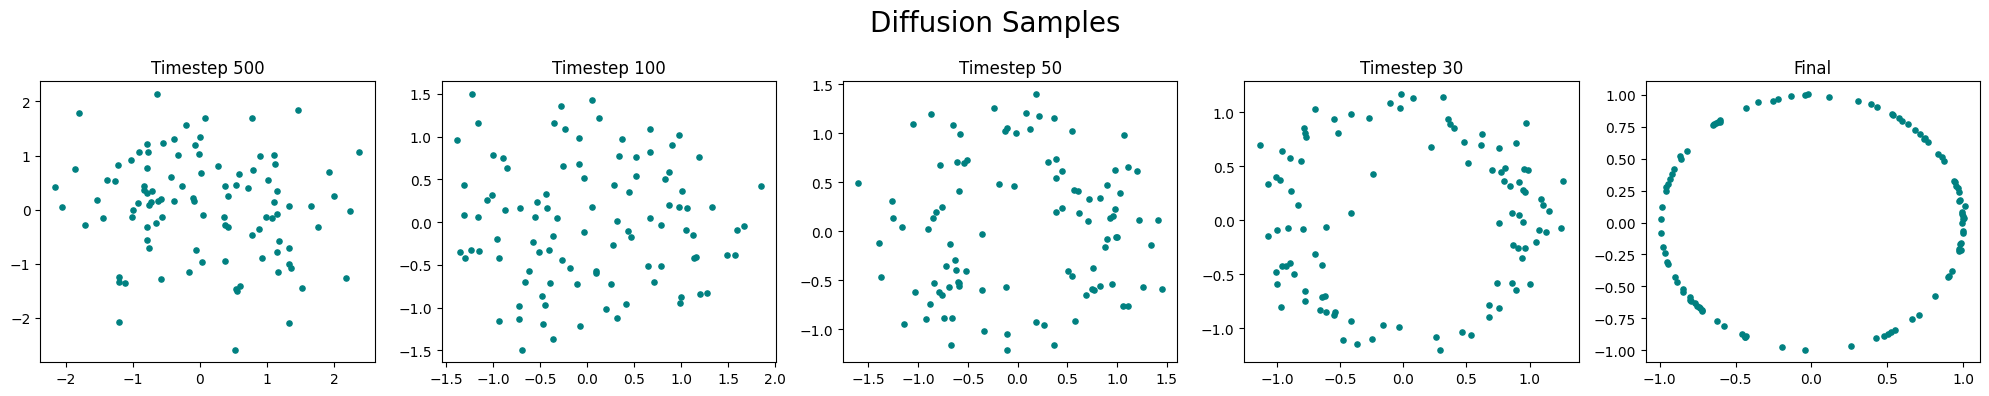

In [439]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4)) 

indices = np.array([0, 400, 450, 470, 500], dtype=np.int)

for i, idx in enumerate(indices):
    axs[i].scatter(series[idx][:,0], series[idx][:,1], s=14.0, color='teal')
    if idx == 500:
        axs[i].set_title(f'Final')
    else:
        axs[i].set_title(f'Timestep {500-idx}')
plt.suptitle('Diffusion Samples', fontsize=20)
plt.tight_layout()
plt.show()

# Diffusion Samples

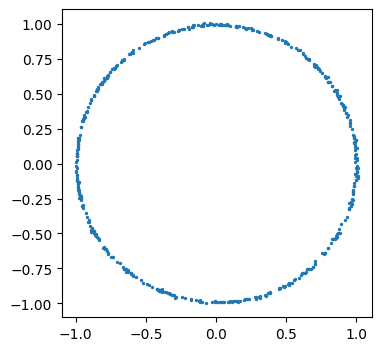

In [353]:

samples = adaptor.sample_x(batch_size=500)
plt.figure(figsize=(4,4))
plt.scatter(samples[:,0], samples[:,1], s=2)
plt.show()

In [287]:
def circle_fid(samples):
    radius = 1
    return (((samples.pow(2)).sum(dim=-1) - radius).pow(2)).mean()

In [348]:
sizes = [20, 50, 100, 500, 1000, 5000, 10000, 20000]
fids = []
ks_stats = []
for size in sizes:
    fid = 0.0
    ks = 0.0
    for it in range(5):
        samples = adaptor.sample_x(batch_size=size)
        fid += circle_fid(samples)
        ks += circle_ks(samples)
    fids.append(fid/5)
    ks_stats.append(ks/5)

In [290]:
def angle_cdf(samples):
    scores = abs(samples[:, 1] / samples[:, 0])

    first_quad_mask = (samples[:, 0] > 0) & (samples[:, 1] > 0)
    second_quad_mask = (samples[:, 0] < 0) & (samples[:, 1] > 0)
    third_quad_mask = (samples[:, 0] < 0) & (samples[:, 1] < 0)
    fourth_quad_mask = (samples[:, 0] > 0) & (samples[:, 1] < 0)
    theta_1 = torch.atan(scores) * first_quad_mask
    theta_1 = theta_1[theta_1 != 0]
    theta_2 = (torch.pi - torch.atan(scores)) * second_quad_mask
    theta_2 = theta_2[theta_2 != 0]
    theta_3 = (torch.pi + torch.atan(scores)) * third_quad_mask
    theta_3 = theta_3[theta_3 != 0]
    theta_4 = (2 * torch.pi - torch.atan(scores)) * fourth_quad_mask
    theta_4 = theta_4[theta_4 != 0]
    thetas, indices = torch.cat([theta_1, theta_2, theta_3, theta_4]).sort(dim=-1)

    return thetas

In [299]:
dist = torch.distributions.uniform.Uniform(0, 2*torch.pi)

In [345]:
def circle_ks(samples):
    dist = torch.distributions.uniform.Uniform(0, 2*torch.pi)
    sample_thetas = angle_cdf(samples)
    
    ecdf = torch.arange(len(samples)) / len(samples)
    true_cdf = dist.cdf(sample_thetas)
    
    return torch.max(torch.abs(dist.cdf(sample_thetas) - ecdf))

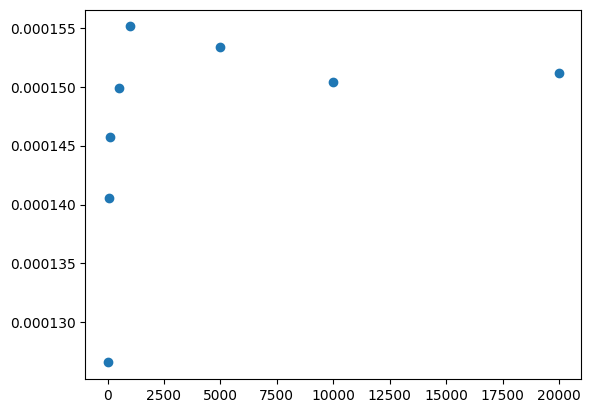

In [488]:
plt.scatter(np.array(sizes), fids)

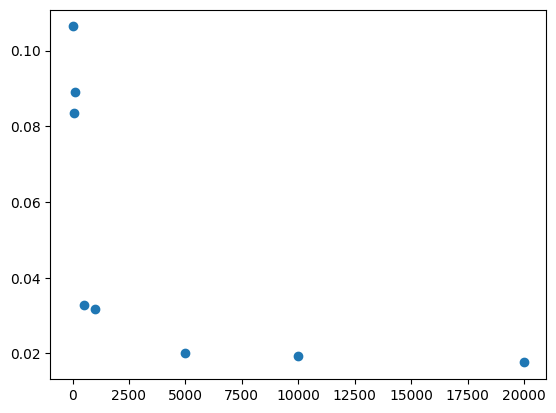

In [350]:
plt.scatter(np.array(sizes), ks_stats)


# Counterfactual Production

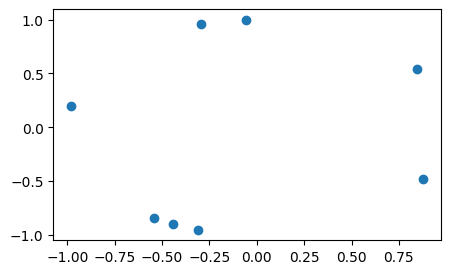

In [442]:
test_dl = DataLoader(test_set, batch_size=8, shuffle=True)
sample, _ = next(iter(test_dl))
plt.figure(figsize=(5,3))
plt.scatter(sample[:,0], sample[:, 1])
plt.show()

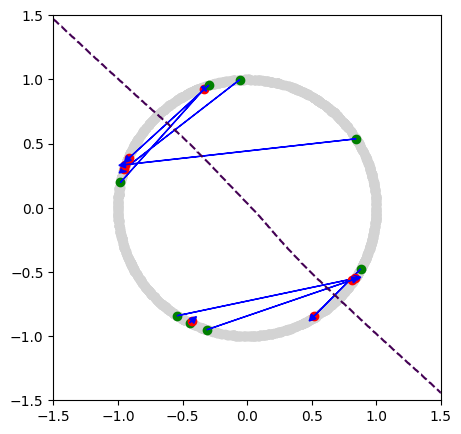

In [463]:
#adaptor_config.generator['grad_scales'] = [1.0, 2.0, 4.0]
#adaptor_config.generator['noise_steps_for_counterfactuals'] = [60, 80]
#adaptor_config.generator['num_iterations'] = 3
list_counterfactuals, diff_latent, y_target_end_confidence, x_list = adaptor.edit(x_in=sample[:,:2], target_confidence_goal=0.9, target_classes=student(sample[:,:2]).argmin(dim=-1), classifier=student)

input_idx = [0,1]
xx1, xx2 = np.meshgrid(*[np.linspace(float(adaptor.data[:, [input_idx]].min()-0.5),float(adaptor.data[:, [input_idx]].max()+0.5), 1000) for idx in input_idx])
grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
z = student(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
adaptor.plot_counterfactuals()
plt.contour(xx1, xx2, z, levels=[0],linestyles='dashed', label='decision boundary')
#plt.legend()
plt.show()

# Counterfactual Analysis

100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.00it/s]


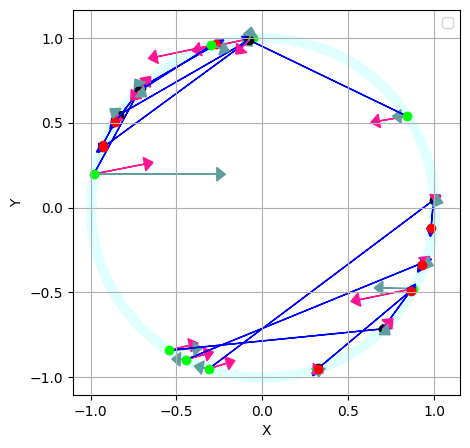

In [477]:
target_classes = student(sample[:,:2]).softmax(dim=-1).argmin(dim=-1)
def plot_counterfactuals(counterfactuals, diffusion_grads, classifier_grads, pointwise_evolution=None, granularity=2):
    #stack = torch.stack(counterfactuals).permute(1, 0, 2) 
    
    bs = len(counterfactuals)
    #nrows = np.ceil(np.sqrt(bs))
    #fig, axs = plt.subplots(nrows=int(nrows), ncols=np.ceil(bs/nrows), figsize=(20, 20))
    
    plt.figure(figsize=(5,5))
    
    plt.scatter(data.data[:,0], data.data[:,1], c='lightcyan')#c=np.where(data.label == 0, 'lightcyan', 'lightgray'))
    
    for i, point in enumerate(counterfactuals):
        skip = point.shape[0]//granularity
        for j in range(0, point.shape[0] - skip, skip): # jth counterfactual
            step = j+skip
            # plot guided gradient at the last point to check direction (even though computer only for the first point)
            plt.arrow(point[j, 0], point[j, 1], 5.0*guided_grads[i][j][0], guided_grads[i][j][1], head_width=0.08, head_length=0.05, fc='deeppink', ec='deeppink')

            # plot the diffusion gradient
            plt.arrow(point[j, 0], point[j, 1], 50.0*unguided_grads[i][j][0], unguided_grads[i][j][1], head_width=0.08, head_length=0.05, fc='cadetblue', ec='cadetblue')
            
            if step>=point.shape[0]:
                break
                step = point.shape[0]
                
            plt.arrow(
                point[j, 0], point[j, 1], # plot the original point plus arrow until (j+granularity)th point
                point[step, 0] - point[j, 0], 
                point[step, 1] - point[j, 1],
                head_width=0.05, head_length=0.05, fc='blue', ec='blue'
            ) 
            plt.scatter(point[step, 0], point[step, 1], color='black')
        
        #if j+skip <point.shape[0]:
        
        if j+skip >= point.shape[0]:
            plt.arrow(point[j, 0], point[j, 1],
                          point[-1, 0] - point[j, 0],
                          point[-1, 1] - point[j, 1],
                          head_width=0.05, head_length=0.05, fc='blue', ec='blue')
            plt.arrow(point[j, 0], point[j, 1], 10.0*guided_grads[i][j][0], guided_grads[i][j][1], head_width=0.08, head_length=0.05, fc='deeppink', ec='deeppink')

            # plot the diffusion gradient
            plt.arrow(point[j, 0], point[j, 1], 10.0*unguided_grads[i][j][0], unguided_grads[i][j][1], head_width=0.08, head_length=0.05, fc='cadetblue', ec='cadetblue')

         
        else:
            plt.arrow(point[j+skip, 0], point[j+skip, 1],
                          point[-1, 0] - point[j+skip, 0],
                          point[-1, 1] - point[j+skip, 1],
                          head_width=0.05, head_length=0.05, fc='blue', ec='blue')
            plt.arrow(point[j+skip, 0], point[j+skip, 1], guided_grads[i][j+skip][0], guided_grads[i][j+skip][1], head_width=0.08, head_length=0.05, fc='deeppink', ec='deeppink')

            # plot the diffusion gradient
            plt.arrow(point[j+skip, 0], point[j+skip,1], unguided_grads[i][j+skip][0], unguided_grads[i][j+skip][1], head_width=0.08, head_length=0.05, fc='cadetblue', ec='cadetblue')
          
            
        # plot the last counterfactual
        #plt.arrow(point[j, 0], point[j, 1],
        #                  point[-1, 0] - point[j, 0],
        #                  point[-1, 1] - point[j, 1],
        #                  head_width=0.05, head_length=0.05, fc='blue', ec='blue')

        
        plt.scatter(point[0, 0], point[0, 1], color='lime')#, label='start')
        plt.scatter(point[-1, 0], point[-1, 1], color='red')#, label='end')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.show()

counterfactuals, guided_grads, unguided_grads, total_series = adaptor.sample_counterfactual_ddpm(clean_batch=sample[:,:2], model=adaptor.model, classifier=student, num_noise_steps=60, target_classes=target_classes, classifier_grad_weight=1.0)
plot_counterfactuals(counterfactuals, unguided_grads, guided_grads)

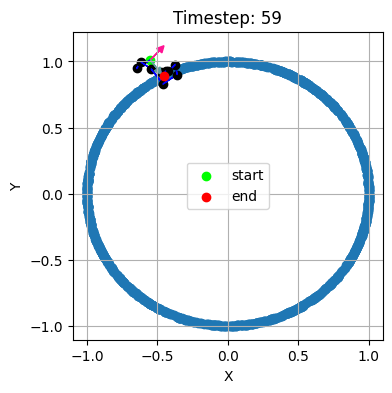

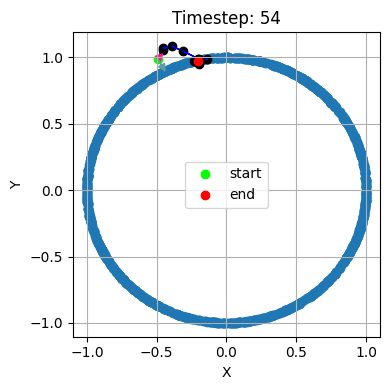

In [472]:
# plotting different series for the same point
point_no = 1

for num_series in [20, 25]:#, 32, 33, 40, 50, 78]: #range(0, len(total_series), len(total_series) // 4):  # only selecting some counterfactuals
    series = total_series[num_series]  # selecting a counterfactual evolution series for one point
    stack = torch.stack(series)
    first_points = stack[:, point_no, :] # second index for different points # we are only taking the first point as above

    skip = len(first_points) // 10 # set steps to skip in each series
    if skip == 0:
        skip = 1
    plt.figure(figsize=(4, 4))
    plt.scatter(data.data[:,0], data.data[:,1])#, c=np.where(data.label == 0, 'lightcyan', 'lightgray'))
    plt.scatter(first_points[0, 0], first_points[0, 1], color='lime', label='start')
    #plt.arrow(first_points[0, 0], first_points[0, 1],
    #              first_points[25, 0] - first_points[0, 0],
    #              first_points[25, 1] - first_points[0, 1],
    #              head_width=0.05, head_length=0.05, fc='blue', ec='blue')
       
    for i in range(0, len(stack)-skip, skip):
        #plt.scatter(first_points[i, 0], first_points[i, 1], color='black')
        plt.arrow(first_points[i, 0], first_points[i, 1],
                  first_points[i+skip, 0] - first_points[i, 0],
                  first_points[i+skip, 1] - first_points[i, 1],
                  head_width=0.00005, head_length=0.000005, fc='blue', ec='blue')
        plt.scatter(first_points[i+skip, 0], first_points[i+skip, 1], color='black')
        


    plt.arrow(first_points[i+skip, 0], first_points[i+skip, 1],
                  first_points[-1, 0] - first_points[i+skip, 0],
                  first_points[-1, 1] - first_points[i+skip, 1],
                  head_width=0.000005, head_length=0.000005, fc='blue', ec='blue')
    plt.arrow(first_points[0, 0], first_points[0, 1], 10*guided_grads[point_no][num_series][0], 10*guided_grads[point_no][num_series][1], head_width=0.05, head_length=0.05, fc='deeppink', ec='deeppink')
    plt.arrow(first_points[0, 0], first_points[0, 1], 10*unguided_grads[point_no][num_series][0], 10*unguided_grads[point_no][num_series][1], head_width=0.05, head_length=0.05, fc='cadetblue', ec='cadetblue')

    plt.scatter(first_points[-1, 0], first_points[-1, 1], color='red', label='end')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.title(f'Timestep: {79 - num_series}')
plt.tight_layout()
plt.show()

In [481]:
fine_tuned = torch.load('peal_runs/artificial_circle_poisened_classifier/cfkd_ddpm_oracle_steps_10_grad_1/model.cpl')

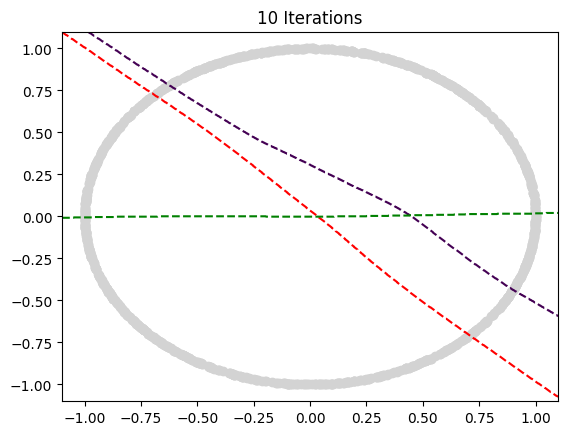

In [484]:
x1_span = np.linspace(-1.1, 1.1, 1000)
x2_span = np.linspace(-1.1, 1.1, 1000)
xx1, xx2 = np.meshgrid(x1_span, x2_span)
grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
fine_tuned.eval()
z = fine_tuned(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
fig, ax = plt.subplots()
a = student(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
b = teacher(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)


data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
for idx, key in enumerate(dataset.data):
    data[idx] = dataset.data[key]
ax.scatter(data[:,0], data[:,1], c=np.where(data[:,-1] == 0, 'lightcyan', 'lightgray')[0])
ax.contour(xx1, xx2, z, levels=[0], linestyles='dashed', label='fine-tuned')
ax.contour(xx1, xx2, a, levels=[0], linestyles='dashed', colors='red', label='student')
ax.contour(xx1, xx2, b, levels=[0], linestyles='dashed', colors='green', label='teacher')
plt.title('10 Iterations')
plt.show()

In [ ]:
fine_tuned = torch.load('peal_runs/artificial_symbolic_100_classifier/cfkd_ddpm_oracle_50/model.cpl')
sum(fine_tuned(torch.tensor(data.data)).softmax(dim=-1).argmax(dim=-1) == torch.tensor(data.label)) / len(data.label)

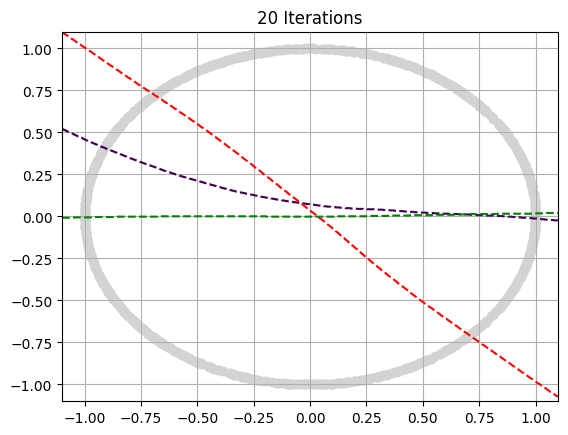

In [487]:
fine_tuned = torch.load('peal_runs/artificial_circle_poisened_classifier/cfkd_ddpm_oracle_steps_20_grad_1/model.cpl')
x1_span = np.linspace(-1.1, 1.1, 1000)
x2_span = np.linspace(-1.1, 1.1, 1000)
xx1, xx2 = np.meshgrid(x1_span, x2_span)
grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
fine_tuned.eval()
z = fine_tuned(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
fig, ax = plt.subplots()
a = student(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
b = teacher(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)


#data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
#for idx, key in enumerate(dataset.data):
#    data[idx] = dataset.data[key]
ax.scatter(data[:,0], data[:,1], c=np.where(data[:,-1] == 0, 'lightcyan', 'lightgray')[0])
ax.contour(xx1, xx2, z, levels=[0], linestyles='dashed', label='fine-tuned')

ax.contour(xx1, xx2, a, levels=[0], linestyles='dashed', colors='red', label='student')
ax.contour(xx1, xx2, b, levels=[0], linestyles='dashed', colors='green', label='teacher')
plt.title('20 Iterations')
ax.grid()

In [ ]:
fine_tuned = torch.load('peal_runs/artificial_symbolic_100_classifier/cfkd_ddpm_oracle_100/model.cpl')
sum(fine_tuned(torch.tensor(data.data)).softmax(dim=-1).argmax(dim=-1) == torch.tensor(data.label)) / len(data.label)

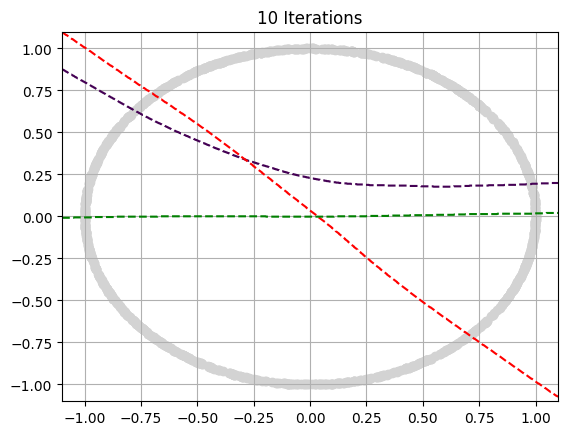

In [490]:
fine_tuned = torch.load('peal_runs/artificial_circle_poisened_classifier/cfkd_ddpm_oracle_steps_30_grad_1/model.cpl')
x1_span = np.linspace(-1.1, 1.1, 1000)
x2_span = np.linspace(-1.1, 1.1, 1000)
xx1, xx2 = np.meshgrid(x1_span, x2_span)
grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
fine_tuned.eval()
z = fine_tuned(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
fig, ax = plt.subplots()
a = student(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
b = teacher(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)


#data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
#for idx, key in enumerate(dataset.data):
#    data[idx] = dataset.data[key]
ax.scatter(data[:,0], data[:,1], c=np.where(data[:,-1] == 0, 'lightcyan', 'lightgray')[0])
ax.contour(xx1, xx2, z, levels=[0], linestyles='dashed', label='fine-tuned')

ax.contour(xx1, xx2, a, levels=[0], linestyles='dashed', colors='red', label='student')
ax.contour(xx1, xx2, b, levels=[0], linestyles='dashed', colors='green', label='teacher')
plt.title('10 Iterations')
ax.grid()

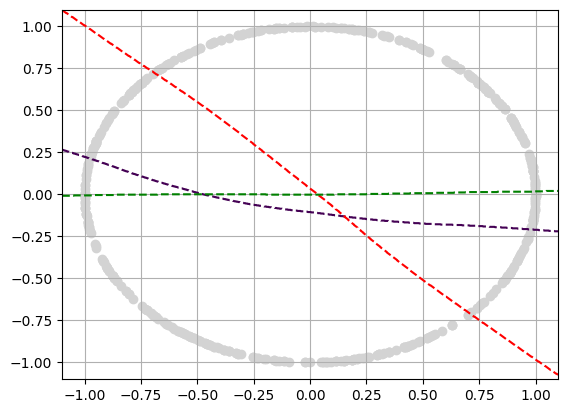

In [24]:
fine_tuned = torch.load('peal_runs/artificial_symbolic_100_classifier/cfkd_ddpm_new_oracle_10/model.cpl')
x1_span = np.linspace(-1.1, 1.1, 1000)
x2_span = np.linspace(-1.1, 1.1, 1000)
xx1, xx2 = np.meshgrid(x1_span, x2_span)
grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
fine_tuned.eval()
z = fine_tuned(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
fig, ax = plt.subplots()
a = student(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
b = teacher(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)


#data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
#for idx, key in enumerate(dataset.data):
#    data[idx] = dataset.data[key]
ax.scatter(adaptor.data[:,0], adaptor.data[:,1], c=np.where(adaptor.data[:,-1] == 0, 'lightcyan', 'lightgray')[0])
ax.contour(xx1, xx2, z, levels=[0], linestyles='dashed', label='fine-tuned')

ax.contour(xx1, xx2, a, levels=[0], linestyles='dashed', colors='red', label='student')
ax.contour(xx1, xx2, b, levels=[0], linestyles='dashed', colors='green', label='teacher')
ax.grid()

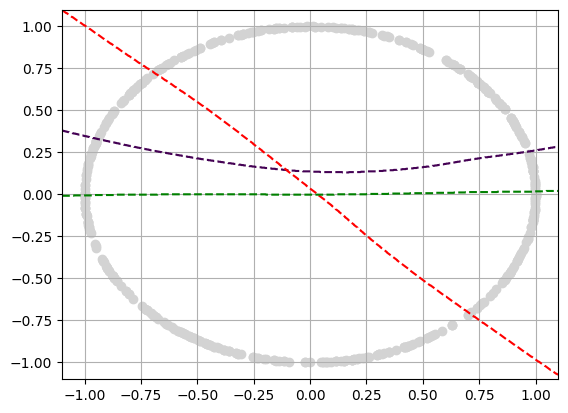

In [25]:
fine_tuned = torch.load('peal_runs/artificial_symbolic_100_classifier/cfkd_ddpm_new_oracle_20/model.cpl')
x1_span = np.linspace(-1.1, 1.1, 1000)
x2_span = np.linspace(-1.1, 1.1, 1000)
xx1, xx2 = np.meshgrid(x1_span, x2_span)
grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
fine_tuned.eval()
z = fine_tuned(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
fig, ax = plt.subplots()
a = student(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
b = teacher(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)


data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
for idx, key in enumerate(dataset.data):
    data[idx] = dataset.data[key]
ax.scatter(data[:,0], data[:,1], c=np.where(data[:,-1] == 0, 'lightcyan', 'lightgray')[0])
ax.contour(xx1, xx2, z, levels=[0], linestyles='dashed', label='fine-tuned')

ax.contour(xx1, xx2, a, levels=[0], linestyles='dashed', colors='red', label='student')
ax.contour(xx1, xx2, b, levels=[0], linestyles='dashed', colors='green', label='teacher')
ax.grid()

In [ ]:
fine_tuned = torch.load('peal_runs/artificial_symbolic_100_classifier/cfkd_ddpm_new_oracle_100/model.cpl')
x1_span = np.linspace(-1.1, 1.1, 1000)
x2_span = np.linspace(-1.1, 1.1, 1000)
xx1, xx2 = np.meshgrid(x1_span, x2_span)
grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
fine_tuned.eval()
z = fine_tuned(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
fig, ax = plt.subplots()
a = student(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
b = teacher(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)


data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
for idx, key in enumerate(dataset.data):
    data[idx] = dataset.data[key]
ax.scatter(data[:,0], data[:,1], c=np.where(data[:,-1] == 0, 'lightcyan', 'lightgray')[0])
ax.contour(xx1, xx2, z, levels=[0], linestyles='dashed', label='fine-tuned')

ax.contour(xx1, xx2, a, levels=[0], linestyles='dashed', colors='red', label='student')
ax.contour(xx1, xx2, b, levels=[0], linestyles='dashed', colors='green', label='teacher')
ax.grid()

In [10]:
import math
from copy import deepcopy
import torch
import torch.nn as nn


import torch.nn.functional as F
from tqdm import tqdm

class DDPM(nn.Module):
    def __init__(self, input_dim: int, embed_dim: int, num_timesteps: int, var_schedule='linear'):
        super(DDPM, self).__init__()

        self.input_dim = input_dim
        self.num_timesteps = num_timesteps

        def linear_schedule(num_timesteps: int):
            scale = 1000 / num_timesteps
            min_var = scale * 1e-5
            max_var = scale * 1e-2
            return torch.linspace(min_var, max_var, num_timesteps, dtype=torch.float32)

        def cosine_schedule(num_timesteps, s=0.008):
            steps = num_timesteps + 1
            x = torch.linspace(0, num_timesteps, steps, dtype=torch.float64)
            alphas_cumprod = torch.cos(((x / num_timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            return torch.clip(betas, 0, 0.999)

        if var_schedule == 'linear':
            betas = linear_schedule(num_timesteps)

        if var_schedule == 'cosine':
            betas = cosine_schedule(num_timesteps)

        self.register_buffer("beta", betas)
        self.register_buffer("alpha", 1 - self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(0))

    def forward_diffusion(self, clean_x: torch.Tensor, noise: torch.tensor, timestep: torch.Tensor):
        timestep = torch.tensor([timestep])
        if timestep.shape[0] == clean_x.shape[0]:
            alpha_bar_t = self.alpha_bar[timestep][:, None]
        else:
            alpha_bar_t = self.alpha_bar[timestep].repeat(clean_x.shape[0])[:, None]
        mu = torch.sqrt(alpha_bar_t)
        std = torch.sqrt(1 - alpha_bar_t)
        noisy_x = mu * clean_x + std * noise
        return noisy_x
    
    
    def forward_diffusion_ddim():
        pass

    def loss(self, model: nn.Module, clean_x: torch.Tensor, loss='L1_simple', var_model: nn.Module=None) -> torch.Tensor:
        t = torch.randint(self.num_timesteps, (clean_x.shape[0],))
        #t = int(torch.rand(1)*self.num_timesteps)
        eps_t = torch.randn_like(clean_x)
        alpha_bar_t = self.alpha_bar[t][:, None]
        
        #x_t = self.forward_diffusion(clean_x=clean_x, noise=eps_t, timestep=t)
        
        x_t = torch.sqrt(alpha_bar_t) * clean_x + torch.sqrt(1 - alpha_bar_t) * eps_t
        
        eps_hat = model(x=x_t, t=t)
        if loss == "L1_simple":
              loss_diff = nn.MSELoss(reduction='sum')(eps_hat, eps_t)

        return loss_diff
    

    def reverse_diffusion_ddpm(self, noisy_x: torch.Tensor, model: nn.Module, timestep: torch.Tensor):
        alpha_t = self.alpha[timestep].repeat(noisy_x.shape[0])[:, None]
        alpha_bar_t = self.alpha_bar[timestep].repeat(noisy_x.shape[0])[:, None]
        beta_t = 1 - alpha_t
        eps_hat = model(x=noisy_x, t=timestep)
        posterior_mean = (1 / torch.sqrt(alpha_t)) * (noisy_x - (beta_t / torch.sqrt(1 - alpha_bar_t) * eps_hat))
        z = torch.randn_like(noisy_x)
        
        if timestep > 0:
            denoised_x = posterior_mean + torch.sqrt(beta_t)*z #* z * (timestep > 0))  # variance = beta_t
        else:
            denoised_x = posterior_mean
                                           
        return denoised_x
    
    def reverse_diffusion_ddim():
        pass


    def sample_ddpm(self, model: nn.Module, n_samples: int = 256, label=None):
        x_pred = []
        x = torch.randn(n_samples, self.input_dim)
        x_pred.append(x)

        with torch.no_grad():
            for t in reversed(range(0, self.num_timesteps)):
                #alpha_t = self.alpha[t].repeat(n_samples)[:, None]
                #alpha_bar_t = self.alpha_bar[t].repeat(n_samples)[:, None]
                #eps_hat = model(x, t)

                #sigma_t = torch.sqrt(1 - self.alpha[t])
                #x_t_mean = (x - eps_hat * (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) / torch.sqrt(alpha_t)

                #if t > 0:
                #    x = x_t_mean + (sigma_t * torch.randn_like(x))
                #else:
                #    x = x_t_mean
                x = self.reverse_diffusion_ddpm(noisy_x=x, model=model, timestep=t)
                
                x_pred.append(x)
                
        return x_pred


    def sample_counterfactual_ddpm(self, clean_batch: torch.Tensor, model: nn.Module, classifier: nn.Module, num_noise_steps: int, counterfactual_class: torch.Tensor, classifier_grad_weight: float, perceptual_weight: float):
        
        classifier.eval()
        
        # DEFINE BATCH SIZE AND COUNTERFACTUAL CLASS
        bs = clean_batch.shape[0]
        #label = torch.tensor(counterfactual_class).repeat(clean_batch.shape[0])
        
        # COMPUTE CLEAN GRADIENTS FOR THE FIRST STEP
        #print(classifier(clean_batch).softmax(dim=-1).argmax(dim=-1))
        classifier_criterion = lambda x: F.cross_entropy(classifier(x), counterfactual_class)
        clean_batch_copy = torch.nn.Parameter(clean_batch)
        loss = classifier_criterion(clean_batch_copy)
        loss.backward()
        
        clean_grad = classifier_grad_weight * clean_batch_copy.grad.detach()
        
        # REDEFINING VARIABLES AND PERFORMING FORWARD DIFFUSION
        #next_z = clean_batch
        eps_t = torch.randn_like(clean_batch)
        
        #next_z = self.forward_diffusion(clean_x=clean_batch, noise=eps_t, timestep=num_noise_steps)
 
        alpha_bar_t = self.alpha_bar[num_noise_steps].repeat(bs)[:, None]
        alpha_t = self.alpha[num_noise_steps].repeat(bs)[:, None]
        next_z = torch.sqrt(alpha_bar_t) * clean_batch + torch.sqrt(1 - alpha_bar_t) * eps_t
        
        #plt.scatter(data.data[:,0], data.data[:,1], c=np.where(data.label == 0, 'lightcyan', 'lightgray'))
        #plt.scatter(next_z[:,0], next_z[:,1])
        
        counterfactuals = [] # total counterfactuals
        counterfactuals.append(clean_batch)
        guided_grads = []  # guided grads at the first step
        unconditional_grads = [] # diffusion grads at the first step 
        total_series = [] # contains evolution from noisy to cleaned instance for each data point
        losses = []
        losses.append(loss)
        for i in tqdm(range(0, num_noise_steps)[::-1]):
            
            # Denoise z_t to create z_t-1 (next z)
            
            alpha_i = self.alpha[i].repeat(bs)[:, None]
            alpha_bar_i = self.alpha_bar[i].repeat(bs)[:, None]
            sigma_i = torch.sqrt(1 - self.alpha[i])
            eps_hat = model(next_z, i)

            # Unconditional mean
            unconditional_grad = -eps_hat / torch.sqrt(1 - alpha_bar_i)
            z_t_mean = (next_z + unconditional_grad * (1 - alpha_i)) / torch.sqrt(alpha_i)

            # Guided mean
            z_t_mean -= sigma_i * (clean_grad / torch.sqrt(alpha_bar_i))

            if i > 0:
                next_z = z_t_mean + (sigma_i * torch.randn_like(clean_batch)) 
            else:
                next_z = z_t_mean

            next_x = next_z.clone()
            # Denoise to create a cleaned x (next x)
            series = []
            series.append(next_x.detach())
            for t in range(0, i)[::-1]:
                if i == 0:
                    break
                #next_x = self.reverse_diffusion_ddpm(noisy_x=next_x, model=model, timestep=t)
                alpha_t = self.alpha[t].repeat(bs)[:, None]
                alpha_bar_t = self.alpha_bar[t].repeat(bs)[:, None]
                sigma_t = torch.sqrt(1 - self.alpha[t])
                eps_hat = model(next_x, t)
                next_x = (next_x - eps_hat * (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) / torch.sqrt(alpha_t)
                if t > 0:
                    next_x = next_x + (sigma_t * torch.randn_like(next_x))
                else:
                    next_x = next_x
                
                series.append(next_x.detach())
            total_series.append(series)
            guided_grads.append(-sigma_i * clean_grad.detach() / torch.sqrt(alpha_bar_i))
            unconditional_grads.append(unconditional_grad.detach() * (1 - alpha_i) / torch.sqrt(alpha_i) )
            
            if i != 0:
                counterfactuals.append(next_x.detach())


            # Gradient wrt denoised image (next_x)
            next_x_copy = torch.nn.Parameter(next_x.clone())
            loss = classifier_criterion(next_x_copy)
            loss.backward()
            losses.append(loss)
            clean_classifier_grad = next_x_copy.grad.detach()
            radius = torch.sqrt((next_x**2).sum(axis=1))
            perceptual_grad = (2 * (radius - 1))[:, None]
            clean_grad = classifier_grad_weight * clean_classifier_grad + perceptual_weight * perceptual_grad
            
            self.counterfactuals = counterfactuals
            self.guided_grads = guided_grads
            self.diffusion_grads = unconditional_grads
            self.pointwise_evolution = total_series 
            
        counterfactuals = torch.stack(counterfactuals).permute(1, 0, 2) 
        guided_grads = torch.stack(guided_grads).permute(1, 0, 2) 
        unguided_grads = torch.stack(unconditional_grads).permute(1, 0, 2)
        #total_series = torch.stack(total_series).permute(1, 0, 2)
            
        return counterfactuals, guided_grads, unguided_grads, total_series
    

    
    def plot_counterfactuals():
        pass



In [11]:
input_dim = 2
embed_dim = 256
T = 500

model = BasicDiscreteTimeModel(input_dim, embed_dim, num_timesteps=T)
ddpm = DDPM(input_dim=input_dim, embed_dim=embed_dim, num_timesteps=T)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.load_state_dict(torch.load('./peal_runs/artificial_symbolic_100_generator/ddpm.pth'))



NameError: name 'BasicDiscreteTimeModel' is not defined

In [ ]:
samples = ddpm.sample_ddpm(model, n_samples=500)
plt.scatter(samples[-1][:,0], samples[-1][:,1])
plt.show()

In [ ]:
target_classes = student(sample[:,:2]).softmax(dim=-1).argmin(dim=-1)

In [ ]:
counterfactuals, guided_grads, unguided_grads, total_series = ddpm.sample_counterfactual_ddpm(clean_batch=sample[:,:2], model=model, classifier=student, num_noise_steps=60, counterfactual_class=target_classes, classifier_grad_weight=1.0, perceptual_weight=0.0)

In [ ]:
from torch.utils.data import Dataset
class CircleDataset(Dataset):
    def __init__(self, data_path: str, features: list[str], labels: list[str]):
        super().__init__()
        data = pd.read_csv(data_path)
        self.data = data[features].to_numpy('float32')
        self.label = data[labels].to_numpy('long')
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx,:], self.label[idx]
    
    def serialize_dataset(self, output_dir: str, x_list: list, y_list: list):
        pass
    
    __name__ = 'circle'
    
data_config = {
    'data_path': 'datasets/circle/size_500_radius_1_seed_0.csv',
    'features': ['x1', 'x2'],
    'target': 'Target'
}

data = CircleDataset(data_path=data_config['data_path'], features=data_config['features'], labels=data_config['target'])

    
def plot_counterfactuals(counterfactuals, diffusion_grads, classifier_grads, pointwise_evolution=None, granularity=2):
    #stack = torch.stack(counterfactuals).permute(1, 0, 2) 
    
    bs = len(counterfactuals)
    #nrows = np.ceil(np.sqrt(bs))
    #fig, axs = plt.subplots(nrows=int(nrows), ncols=np.ceil(bs/nrows), figsize=(20, 20))
    
    plt.figure(figsize=(5,5))
    
    plt.scatter(data.data[:,0], data.data[:,1], c='lightcyan')#c=np.where(data.label == 0, 'lightcyan', 'lightgray'))
    
    for i, point in enumerate(counterfactuals):
        skip = point.shape[0]//granularity
        for j in range(0, point.shape[0] - skip, skip): # jth counterfactual
            step = j+skip
            # plot guided gradient at the last point to check direction (even though computer only for the first point)
            plt.arrow(point[j, 0], point[j, 1], 5.0*guided_grads[i][j][0], 5.0*guided_grads[i][j][1], head_width=0.08, head_length=0.05, fc='deeppink', ec='deeppink')

            # plot the diffusion gradient
            plt.arrow(point[j, 0], point[j, 1], 20.0*unguided_grads[i][j][0], 20.0*unguided_grads[i][j][1], head_width=0.08, head_length=0.05, fc='cadetblue', ec='cadetblue')
            
            if step>=point.shape[0]:
                break
                step = point.shape[0]
                
            plt.arrow(
                point[j, 0], point[j, 1], # plot the original point plus arrow until (j+granularity)th point
                point[step, 0] - point[j, 0], 
                point[step, 1] - point[j, 1],
                head_width=0.05, head_length=0.05, fc='blue', ec='blue'
            ) 
            plt.scatter(point[step, 0], point[step, 1], color='black')
        
        #if j+skip <point.shape[0]:
        
        if j+skip >= point.shape[0]:
            plt.arrow(point[j, 0], point[j, 1],
                          point[-1, 0] - point[j, 0],
                          point[-1, 1] - point[j, 1],
                          head_width=0.05, head_length=0.05, fc='blue', ec='blue')
            plt.arrow(point[j, 0], point[j, 1], 10.0*guided_grads[i][j][0], 10.0*guided_grads[i][j][1], head_width=0.08, head_length=0.05, fc='deeppink', ec='deeppink')

            # plot the diffusion gradient
            plt.arrow(point[j, 0], point[j, 1], 50.0*unguided_grads[i][j][0], 50.0*unguided_grads[i][j][1], head_width=0.08, head_length=0.05, fc='cadetblue', ec='cadetblue')

         
        else:
            plt.arrow(point[j+skip, 0], point[j+skip, 1],
                          point[-1, 0] - point[j+skip, 0],
                          point[-1, 1] - point[j+skip, 1],
                          head_width=0.05, head_length=0.05, fc='blue', ec='blue')
            plt.arrow(point[j+skip, 0], point[j+skip, 1], 10.0*guided_grads[i][j+skip][0], 10.0*guided_grads[i][j+skip][1], head_width=0.08, head_length=0.05, fc='deeppink', ec='deeppink')

            # plot the diffusion gradient
            plt.arrow(point[j+skip, 0], point[j+skip,1], 50.0*unguided_grads[i][j+skip][0], 50.0*unguided_grads[i][j+skip][1], head_width=0.08, head_length=0.05, fc='cadetblue', ec='cadetblue')
          
            
        # plot the last counterfactual
        #plt.arrow(point[j, 0], point[j, 1],
        #                  point[-1, 0] - point[j, 0],
        #                  point[-1, 1] - point[j, 1],
        #                  head_width=0.05, head_length=0.05, fc='blue', ec='blue')

        
        plt.scatter(point[0, 0], point[0, 1], color='lime', label='start')
        plt.scatter(point[-1, 0], point[-1, 1], color='red', label='end')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.show()

counterfactuals, guided_grads, unguided_grads, total_series = adaptor.sample_counterfactual_ddpm(clean_batch=sample[:,:2], model=adaptor.model, classifier=student, num_noise_steps=80, target_classes=target_classes, classifier_grad_weight=15.0)
plot_counterfactuals(counterfactuals[1:2,:], unguided_grads, guided_grads)

In [ ]:
len(total_series[0])

In [ ]:
# plotting different series for the same point
point_no = 1

for num_series in [20, 25]:#, 32, 33, 40, 50, 78]: #range(0, len(total_series), len(total_series) // 4):  # only selecting some counterfactuals
    series = total_series[num_series]  # selecting a counterfactual evolution series for one point
    stack = torch.stack(series)
    first_points = stack[:, point_no, :] # second index for different points # we are only taking the first point as above

    skip = len(first_points) // 10 # set steps to skip in each series
    if skip == 0:
        skip = 1
    plt.figure(figsize=(4, 4))
    plt.scatter(data.data[:,0], data.data[:,1])#, c=np.where(data.label == 0, 'lightcyan', 'lightgray'))
    plt.scatter(first_points[0, 0], first_points[0, 1], color='lime', label='start')
    #plt.arrow(first_points[0, 0], first_points[0, 1],
    #              first_points[25, 0] - first_points[0, 0],
    #              first_points[25, 1] - first_points[0, 1],
    #              head_width=0.05, head_length=0.05, fc='blue', ec='blue')
       
    for i in range(0, len(stack)-skip, skip):
        #plt.scatter(first_points[i, 0], first_points[i, 1], color='black')
        plt.arrow(first_points[i, 0], first_points[i, 1],
                  first_points[i+skip, 0] - first_points[i, 0],
                  first_points[i+skip, 1] - first_points[i, 1],
                  head_width=0.00005, head_length=0.000005, fc='blue', ec='blue')
        plt.scatter(first_points[i+skip, 0], first_points[i+skip, 1], color='black')
        


    plt.arrow(first_points[i+skip, 0], first_points[i+skip, 1],
                  first_points[-1, 0] - first_points[i+skip, 0],
                  first_points[-1, 1] - first_points[i+skip, 1],
                  head_width=0.000005, head_length=0.000005, fc='blue', ec='blue')
    plt.arrow(first_points[0, 0], first_points[0, 1], 10*guided_grads[point_no][num_series][0], 10*guided_grads[point_no][num_series][1], head_width=0.05, head_length=0.05, fc='deeppink', ec='deeppink')
    plt.arrow(first_points[0, 0], first_points[0, 1], 10*unguided_grads[point_no][num_series][0], 10*unguided_grads[point_no][num_series][1], head_width=0.05, head_length=0.05, fc='cadetblue', ec='cadetblue')

    plt.scatter(first_points[-1, 0], first_points[-1, 1], color='red', label='end')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.title(f'Timestep: {79 - num_series}')
plt.tight_layout()
plt.show()

In [ ]:
x = np.array([10, 16, 20])
y = np.array([0.7680, 0.8680, 0.9020])

In [ ]:
plt.plot(x, y, marker='o')
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(xi, yi, f'({yi})', fontsize=12, ha='right', va='bottom')

plt.xlabel('No. of Iterations')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
?plt.plot

In [ ]:
    def discard_counterfactuals(self, counterfactuals, classifier, target_classes, target_confidence, minimal_counterfactuals, tolerance=0.1):
        
        # compute distance of current minimal_counterefactuals from radius 1.0
        current_counterfactual_distance_from_manifold = torch.abs((torch.pow(minimal_counterfactuals, 2).sum(dim=-1) - 1.0))
        
        for i in range(len(counterfactuals)):  

            # compute classifier  for all the counterfactuals for each point
            new_counterfactuals_confidence = classifier(counterfactuals[i]).softmax(dim=-1)[:, target_classes[i]]
            
            
            # check if new counterfactuals satisfy the confidence constraint
            new_confidence_satisfied = new_counterfactuals_confidence > target_confidence
            
            new_confidence_satisfied_indices = torch.nonzero(new_counterfactuals_confidence > target_confidence)
            
            
            # 
            new_tolerance_satisfied = torch.abs((torch.pow(counterfactuals[i], 2).sum(dim=-1) - 1.0)) < tolerance
            new_tolerance_satisfied_indices = torch.nonzero(torch.abs((torch.pow(counterfactuals[i], 2).sum(dim=-1) - 1.0)) < tolerance)
            
            # check where target confidence is reached AND if new counterfactuals are within the tolerance range
            #indices = torch.nonzero((confidence > target_confidence) 
            #                    (torch.abs((torch.pow(counterfactuals[i], 2).sum(dim=-1) - 1.0)) < tolerance))
            
            
            new_confidence_and_tolerance_satisfied_indices = torch.nonzero(new_confidence_satisfied & new_tolerance_satisfied)
            
            current_tolerance_satisfied = current_counterfactual_distance_from_manifold[i] < tolerance
            #classifier(minimal_counterfactuals[i:i+1]).softmax(dim=-1)[0][target_classes[i]]
            current_confidence_satisfied = classifier(minimal_counterfactuals[i:i+1]).softmax(dim=-1)[0][target_classes[i]].item() > target_confidence
            
            # if current counterfactual satisfies confidence and tolerance, maintain status quo 
            
            
            
            if (current_tolerance_satisfied) and (current_confidence_satisfied):
            
                #print(f'confidence and tolerance satisfied for {i}')
                continue
          
            # if new target confidence and current target confidence not satisfied
            # but new tolerance is satisfied, then move the point closer
            elif (new_tolerance_satisfied_indices.nelement() !=0) & (new_confidence_satisfied_indices.nelement() == 0) and (not current_confidence_satisfied):
                minimal_counterfactuals[i] = counterfactuals[i][torch.nonzero(new_tolerance_satisfied)[-1].item()]
            
              
            # if current counterfactual is on the manifold but is not actually a counterfactual, 
            # replace it with new counterfactual if there exists any 
            elif (not current_confidence_satisfied) & (new_confidence_and_tolerance_satisfied_indices.nelement() != 0):
                # change this to only include the first where confidence and tolerance is satisfied
                minimal_counterfactuals[i] = counterfactuals[i][new_confidence_and_tolerance_satisfied_indices[0].item()]
                
            else:
                continue
            

        return minimal_counterfactuals
